## Association Analysis

Association analysis uses an algorithm that extracts hidden relationships from large datasets. For this analysis, the Apriori algorithm will be used. The dataset, which comes from a bakery, has around 9000 records with four columns each: date, time, transaction, and item. 

### Set up Environment 

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

%matplotlib inline

### Read in Data 

In [2]:
def load_dataset(file_name):
    with open(file_name, 'r') as f:
        content = f.readlines()[1:]
    transactions = []
    prev_tid = -1
    for t in content:
        t = t.strip().split(',')[-2:]
        tid = t[0]
        item = t[1]
        if prev_tid != tid:
            prev_tid = tid
            transactions.append([item])
        else:
            transactions[-1].append(item)
    return transactions

In [3]:
# load data 
data = load_dataset('BreadBasket_DMS.csv')

# length + preview 
print('num transactions:', len(data))
data[:20]

num transactions: 9531


[['Bread'],
 ['Scandinavian', 'Scandinavian'],
 ['Hot chocolate', 'Jam', 'Cookies'],
 ['Muffin'],
 ['Coffee', 'Pastry', 'Bread'],
 ['Medialuna', 'Pastry', 'Muffin'],
 ['Medialuna', 'Pastry', 'Coffee', 'Tea'],
 ['Pastry', 'Bread'],
 ['Bread', 'Muffin'],
 ['Scandinavian', 'Medialuna'],
 ['Bread', 'Medialuna', 'Bread', 'NONE'],
 ['Jam', 'Coffee', 'Tartine', 'Pastry', 'Tea'],
 ['Basket', 'Bread', 'Coffee'],
 ['Bread', 'Medialuna', 'Pastry'],
 ['NONE', 'NONE', 'Mineral water', 'Scandinavian'],
 ['Bread', 'Medialuna', 'Coffee'],
 ['Hot chocolate'],
 ['Farm House'],
 ['Farm House', 'Bread'],
 ['Bread', 'Medialuna']]

### Data Preprocessing 

The dataset contains some transactions labeled as 'NONE' meaning that they need to be removed in order to proceed with our analysis. Additionally, an item count needs to be generated from the dataset and sorted in descending order. 

In [4]:
# drops NONE values, takes in 2d list, returns 2d list with NONE values removed
def drop_none(dataset): 
    for i in range(len(dataset)):
        try: 
            if (dataset[i] == ['NONE']): 
                del dataset[i]
            else: 
                count = dataset[i].count('NONE')
                if (count > 0):
                    for j in range(count): 
                        dataset[i].remove('NONE')
        
        except IndexError: 
            break
            
    return dataset

# creates item dictionary, takes in 2d list, returns item count dictionary 
def item_count(dataset): 
    items = {}
    for lst in data: 
        for i in lst: 
            if (i not in items): 
                items[i] = 1 
            else: 
                items[i] += 1 
                
    return items 

In [5]:
# drop NONE values 
data = drop_none(data)

# create itemcount list, sort 
items = sorted(item_count(data).items(), key=lambda x:x[1], reverse=True)

To get a better look at the data, lets plot the top ten best-selling items from the set. 

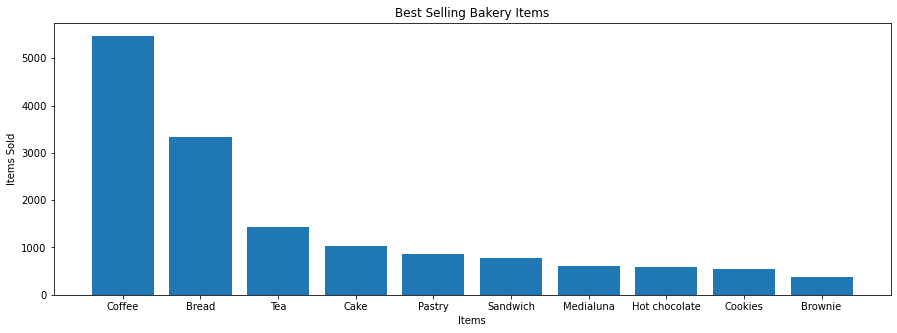

In [6]:
# plot 10 best selling items 
plt.figure(figsize=(15, 5))
plt.bar([x[0] for x in items[:10]], [x[1] for x in items[:10]])
plt.title('Best Selling Bakery Items')
plt.xlabel('Items')
plt.ylabel('Items Sold')
plt.show()

Now, the next step is to use mlxtend's TransactionEncoder to transform the dataset into an array format for the mlxtend library. The function learns unique items from the dataset and transforms each transaction into a one-hot encoded numpy array. 

In [7]:
# create transaction encoder 
tencoder = TransactionEncoder()

# create dataframe from encoded data 
encoded_data = pd.DataFrame(tencoder.fit_transform(data), columns=tencoder.columns_)
encoded_data.sample(10)

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
2955,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
7179,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6374,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1686,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7180,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6761,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6737,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2240,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2675,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2833,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Now that the data has been encoded, it can now be ran through the mlxtend's apriori function to generate itemsets.  

### Frequent Itemsets

#### Apriori

The Apriori algorithm extracts frequent itemsets with the application of association rule learning. The minimum support will be set to 0.01, which is defined as a set of items that occur together in at least 0.01% of all transactions.

In [8]:
# apriori algorithm 
itemsets = apriori(encoded_data, min_support=0.01, use_colnames=True) 
itemsets

,support,itemsets
0,0.036318,(Alfajores)
1,0.016047,(Baguette)
2,0.326964,(Bread)
3,0.040013,(Brownie)
4,0.103780,(Cake)
...,...,...
56,0.023649,"(Toast, Coffee)"
57,0.014358,"(Tea, Sandwich)"
58,0.010030,"(Cake, Bread, Coffee)"
59,0.011191,"(Bread, Pastry, Coffee)"


### Maximal and Closed Frequent Itemsets

The itemsets data contains all frequent itemsets, but there are only two specific itemsets of interest: maximal and closed frequent itemsets. Maximal frequent itemsets are frequent itemsets that have no superset while closed frequent itemsets are frequent itemsets with no superset with the same support count. To find these itemsets, the following functions were created:

In [9]:
# takes in itemsets df, returns maximum frequent itemsets df
def mfitemsets(itemsets): 
    subsets = []
    items = itemsets.itemsets # [x[1] for x in itemsets.values]

    for item1 in items: 
        for item2 in items: 
            if len(item1) >= len(item2): 
                continue 
            elif item1.issubset(item2):
                subsets.append(item1)
    
    mfi = itemsets[~itemsets['itemsets'].isin(subsets)]
    return mfi

# takes in itemsets df, returns closed frequent items df 
def cfitemsets(itemsets): 
    su = itemsets.support.unique()
    items = itemsets.itemsets
    closed = [] 
    
    for item1 in items: 
        c = 1
        for item2 in items: 
            if len(item2) <= len(item1): 
                continue 
            elif item2.issuperset(item1):
                s1 = float(itemsets[itemsets['itemsets'] == item1].support)
                s2 = float(itemsets[itemsets['itemsets'] == item2].support)
                if s1 == s2: 
                    c = 0
        if c == 1:
            closed.append(item1)
    cfi = itemsets[itemsets['itemsets'].isin(closed)]
    return cfi

Now, lets generate the maximal and closed frquent itemsets: 

#### Maximal Frequent Itemsets

In [10]:
# generate maximal frquent itemsets
mfi = mfitemsets(itemsets)
print(f'maximal frequent itemsets: {len(mfi)}')
mfi.head(10)

maximal frequent itemsets: 37


,support,itemsets
1,0.016047,(Baguette)
5,0.012986,(Chicken Stew)
7,0.019426,(Coke)
9,0.039168,(Farm House)
10,0.014992,(Fudge)
11,0.010557,(Hearty & Seasonal)
13,0.014992,(Jam)
14,0.013197,(Jammie Dodgers)
17,0.014147,(Mineral water)
20,0.010452,(Salad)


#### Closed Frequent Itemsets

In [11]:
cfi = cfitemsets(itemsets)
print(f'closed frequent itemsets: {len(cfi)}')
cfi.head(10)

closed frequent itemsets: 61


,support,itemsets
0,0.036318,(Alfajores)
1,0.016047,(Baguette)
2,0.326964,(Bread)
3,0.040013,(Brownie)
4,0.103780,(Cake)
5,0.012986,(Chicken Stew)
6,0.478041,(Coffee)
7,0.019426,(Coke)
8,0.054371,(Cookies)
9,0.039168,(Farm House)


### Association Rules

Now, lets use the Association Rules algorithm to generate the frquent itemsets. To start, the confidence level will be set to 0.25. 

In [32]:
itemsets_ar = association_rules(itemsets, metric='confidence', min_threshold=0.25)
itemsets_ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Alfajores),(Bread),0.036318,0.326964,0.010346,0.284884,0.871301,-0.001528,0.941156
1,(Alfajores),(Coffee),0.036318,0.478041,0.019637,0.540698,1.131071,0.002276,1.136418
2,(Brownie),(Bread),0.040013,0.326964,0.010769,0.269129,0.823117,-0.002314,0.920869
3,(Bread),(Coffee),0.326964,0.478041,0.089949,0.275105,0.575485,-0.066353,0.720048
4,(Cookies),(Bread),0.054371,0.326964,0.014464,0.266019,0.813605,-0.003314,0.916967
5,(Medialuna),(Bread),0.061761,0.326964,0.016892,0.273504,0.836497,-0.003302,0.926415
6,(Pastry),(Bread),0.086043,0.326964,0.029139,0.338650,1.035743,0.001006,1.017671
7,(Brownie),(Coffee),0.040013,0.478041,0.019637,0.490765,1.026618,0.000509,1.024988
8,(Cake),(Coffee),0.103780,0.478041,0.054688,0.526958,1.102330,0.005077,1.103411
9,(Cookies),(Coffee),0.054371,0.478041,0.028188,0.518447,1.084524,0.002197,1.083908


Compared to the Apriori algorithm, the Association Rules algorithm generated a lot less itemsets. A crucial step in generating a set of rules is to determine optimal threshold for support and confidence. To find the best threshold, lets create a plot: 

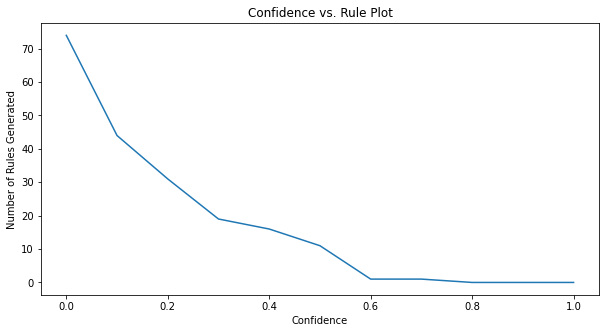

In [34]:
# rules / confidence lists
rules = [] 
confidence = [] 

# generate rules / confidence 
for i in np.arange(0, 1.1, 0.1): 
    ar = association_rules(itemsets, metric='confidence', min_threshold=i)
    confidence.append(i)
    rules.append(ar.shape[0])
    
# plot 
plt.figure(figsize=(10, 5))
plt.plot(confidence, rules) 
plt.title('Confidence vs. Rule Plot')
plt.xlabel('Confidence')
plt.ylabel('Number of Rules Generated')
plt.show()

Based off the plot, the confidence and number of rules genrated have an inverse relationship. Therefore, an ideal range for the confidence value seems to be around 0.3-0.6. For the final model, lets set the confidence to 0.5: 

In [36]:
itemsets_ar = association_rules(itemsets, metric='confidence', min_threshold=0.5)
itemsets_ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Alfajores),(Coffee),0.036318,0.478041,0.019637,0.540698,1.131071,0.002276,1.136418
1,(Cake),(Coffee),0.103780,0.478041,0.054688,0.526958,1.102330,0.005077,1.103411
2,(Cookies),(Coffee),0.054371,0.478041,0.028188,0.518447,1.084524,0.002197,1.083908
3,(Hot chocolate),(Coffee),0.058277,0.478041,0.029561,0.507246,1.061095,0.001702,1.059271
4,(Juice),(Coffee),0.038535,0.478041,0.020587,0.534247,1.117576,0.002166,1.120678
5,(Medialuna),(Coffee),0.061761,0.478041,0.035156,0.569231,1.190758,0.005632,1.211692
6,(Pastry),(Coffee),0.086043,0.478041,0.047508,0.552147,1.155022,0.006376,1.165471
7,(Sandwich),(Coffee),0.071791,0.478041,0.038218,0.532353,1.113615,0.003899,1.116140
8,(Scone),(Coffee),0.034523,0.478041,0.018053,0.522936,1.093915,0.001550,1.094107
9,(Spanish Brunch),(Coffee),0.018159,0.478041,0.010874,0.598837,1.252691,0.002194,1.301116


With confidence set at 0.5, there were ten rules generated with coffee as the only consequent as well as a very close to one, which may indicate that both of the items are independent of each other.  